In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

FRAMNA_BACKGROUND = "#FFFFFF"
FRAMNA_BLACK = "#000000"
FRAMNA_GREEN = "#1CB65D"
FRAMNA_BLUE = "#E3EFF1"
FRAMNA_RED = "#B20126"
FRAMNA_DARK_BLUE = "#305381"

def apply_framna_axes_style(ax):
    ax.set_facecolor(FRAMNA_BLUE)
    ax.grid(True, axis="y", alpha=0.22, linestyle="--")
    ax.grid(False, axis="x")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_alpha(0.35)
    ax.spines["bottom"].set_alpha(0.35)
    ax.tick_params(axis="both", labelsize=10, colors=FRAMNA_BLACK)
    return ax

def apply_time_axis(ax, start=None, end=None):
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=[30]))
    ax.tick_params(axis='x', rotation=90, colors=FRAMNA_BLACK)
    if start is not None and end is not None:
        ax.set_xlim(start, end)
    return ax

def add_kpi_box(ax, lines, *, loc=(0.01, 0.98)):
    text = "\n".join(lines)
    ax.text(
        loc[0],
        loc[1],
        text,
        transform=ax.transAxes,
        ha="left",
        va="top",
        fontsize=10,
        color=FRAMNA_BLACK,
        bbox=dict(boxstyle="round,pad=0.35", facecolor=FRAMNA_BACKGROUND, edgecolor="none", alpha=0.9),
        zorder=20,
    )

def compute_costs(df, *, interval_hours=0.25):
    df = df.copy()
    df["calculated_cost_eur"] = (df["watts_on"] / 1000) * interval_hours * df["current_spot_price_eur_kwh"]
    energy_kwh = df["watts_on"].sum() / 1000 * interval_hours
    total_cost = df["calculated_cost_eur"].sum()
    avg_price_paid = (total_cost / energy_kwh) if energy_kwh > 0 else 0.0
    return df, energy_kwh, total_cost, avg_price_paid

def add_comfort_band(ax, *, low=None, high=None, label="Comfort band"):
    if low is None or high is None:
        return None
    patch = ax.axhspan(low, high, color=FRAMNA_GREEN, alpha=0.08, zorder=0, label=label)
    return patch

def action_to_state(df, *, on_value=1, off_value=0):
    if "action" not in df.columns:
        return None
    s = pd.Series(index=df.index, dtype="float")
    s[df["action"] == "ON"] = on_value
    s[df["action"] == "OFF"] = off_value
    s = s.ffill().fillna(off_value)
    return s

def style_ax(ax, xlabel, ylabel, title):
    apply_framna_axes_style(ax)
    ax.set_xlabel(xlabel, fontsize=12, fontweight="medium", color=FRAMNA_BLACK)
    ax.set_ylabel(ylabel, fontsize=12, fontweight="medium", color=FRAMNA_BLACK)
    ax.set_title(title, fontsize=14, fontweight="semibold", pad=20, color=FRAMNA_BLACK)
    return ax

# Load data
df_dp = pd.read_csv("stats_2025-10-15_16-59-11.csv")
df_dp['datetime'] = pd.to_datetime(df_dp['datetime'])

df_hys = pd.read_csv("stats_2025-10-16_12-37-18.csv")
df_hys['datetime'] = pd.to_datetime(df_hys['datetime'])

# Pre-compute costs (used in plots + prints)
df_dp_cost, dp_energy_kwh, dp_total_cost, dp_avg_price = compute_costs(df_dp)
df_hys_cost, hys_energy_kwh, hys_total_cost, hys_avg_price = compute_costs(df_hys)

df_dp_cost.head()

,step,datetime,action,watts_on,current_temp_c,ambient_temp_c,current_spot_price_eur_kwh,heating_rate_k_per_step,cooling_coefficient,predicted_next_temp_c,predicted_cost_eur,fcr_revenue_eur,fcr_d_down_price_eur,fcr_d_up_price_eur,calculated_cost_eur
0,0,2025-10-15 16:59:16.494927,ON,450.8,21.125,12.6,0.13657,0.5,0.020000,21.454500,0.017071,0.000431,0.003448,0.004868,0.015391
1,1,2025-10-15 17:14:19.068344,OFF,0.0,21.187,12.8,0.16988,0.5,0.020000,21.019260,0.000000,0.000549,0.003448,0.004868,0.000000
2,2,2025-10-15 17:29:21.632339,OFF,0.0,21.000,12.8,0.16988,0.5,0.022296,20.817172,0.000000,0.000000,0.003448,0.004868,0.000000
3,3,2025-10-15 17:44:23.987140,OFF,0.0,20.687,12.8,0.16988,0.5,0.030000,20.450390,0.000000,0.000000,0.003448,0.004868,0.000000
4,4,2025-10-15 17:59:27.458535,OFF,0.0,20.437,12.8,0.16988,0.5,0.030000,20.207890,0.000000,0.000000,0.003448,0.004868,0.000000


Total cost: 0.3094 EUR
Energy consumed: 2.86 kWh
Avg price paid: 0.1082 EUR/kWh


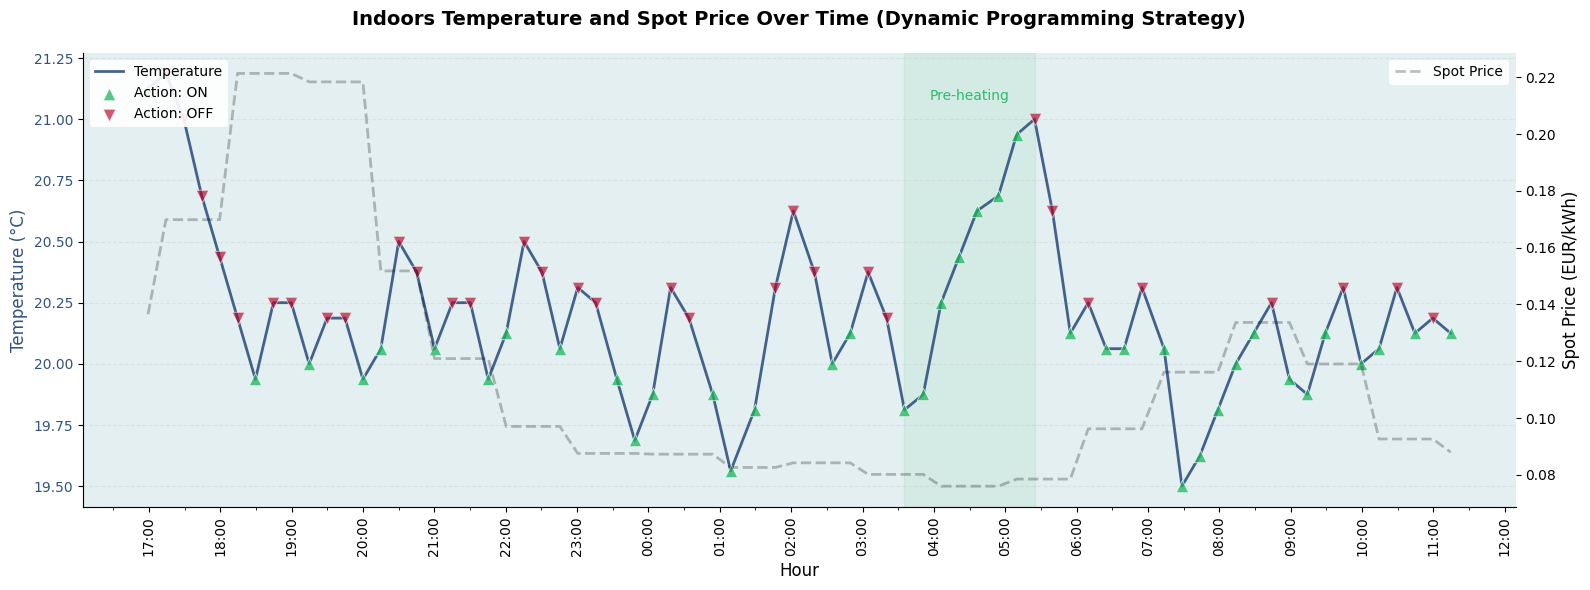

In [ ]:
fig, ax1 = plt.subplots(figsize=(16, 6))
fig.set_facecolor(FRAMNA_BACKGROUND)
apply_framna_axes_style(ax1)

# Plot temperature on the left y-axis
ax1.set_xlabel('Hour', fontsize=12, fontweight="medium", color=FRAMNA_BLACK)
ax1.set_ylabel('Temperature (°C)', fontsize=12, fontweight="medium", color=FRAMNA_DARK_BLUE)
ax1.plot(
    df_dp['datetime'],
    df_dp['current_temp_c'],
    color=FRAMNA_DARK_BLUE,
    linewidth=2.0,
    alpha=0.9,
    label='Temperature',
    zorder=3,
 )
ax1.tick_params(axis='y', labelcolor=FRAMNA_DARK_BLUE)

# Add triangle indicators 
df_on = df_dp[df_dp['action'] == 'ON']
df_off = df_dp[df_dp['action'] == 'OFF']

ax1.scatter(
    df_on['datetime'],
    df_on['current_temp_c'],
    marker='^',
    s=80,
    color=FRAMNA_GREEN,
    alpha=0.75,
    edgecolors=FRAMNA_BACKGROUND,
    linewidths=0.6,
    label='Action: ON',
    zorder=5,
 )
ax1.scatter(
    df_off['datetime'],
    df_off['current_temp_c'],
    marker='v',
    s=80,
    color=FRAMNA_RED,
    alpha=0.65,
    edgecolors=FRAMNA_BACKGROUND,
    linewidths=0.6,
    label='Action: OFF',
    zorder=5,
 )

# Create a second y-axis for spot price on the right
ax2 = ax1.twinx()
ax2.set_ylabel('Spot Price (EUR/kWh)', fontsize=12, fontweight="medium", color=FRAMNA_BLACK)
ax2.plot(
    df_dp['datetime'],
    df_dp['current_spot_price_eur_kwh'],
    color=FRAMNA_BLACK,
    alpha=0.25,
    linewidth=2,
    linestyle='--',
    label='Spot Price',
    zorder=2,
 )
ax2.tick_params(axis='y', labelcolor=FRAMNA_BLACK)
ax2.grid(False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

apply_time_axis(ax1)

# Add title
ax1.set_title(
    'Indoors Temperature and Spot Price Over Time (Dynamic Programming Strategy)',
    fontsize=14,
    fontweight="semibold",
    pad=20,
    color=FRAMNA_BLACK,
 )

# Add pre-heating highlight region
preheat_start = df_dp[(df_dp['datetime'].dt.hour == 3) & (df_dp['datetime'].dt.minute == 35)]['datetime'].min()
preheat_end = df_dp[(df_dp['datetime'].dt.hour == 5) & (df_dp['datetime'].dt.minute == 24)]['datetime'].min()

if pd.notna(preheat_start) and pd.notna(preheat_end):
    ax1.axvspan(preheat_start, preheat_end, alpha=0.08, color=FRAMNA_GREEN, zorder=0)
    mid_time = preheat_start + (preheat_end - preheat_start) / 2
    y_top = ax1.get_ylim()[1]
    ax1.text(
        mid_time,
        y_top - 0.15,
        'Pre-heating',
        fontsize=10,
        fontweight='medium',
        ha='center',
        va='top',
        color=FRAMNA_GREEN,
        alpha=0.9,
    )

# Legends
leg1 = ax1.legend(loc='upper left', framealpha=0.9, facecolor=FRAMNA_BACKGROUND, edgecolor='none')
leg1.set_zorder(1000)
leg2 = ax2.legend(loc='upper right', framealpha=0.9, facecolor=FRAMNA_BACKGROUND, edgecolor='none')
leg2.set_zorder(1000)

fig.tight_layout()

# Print KPIs (from pre-computed costs)
print(f"Total cost: {dp_total_cost:.4f} EUR")
print(f"Energy consumed: {dp_energy_kwh:.2f} kWh")
print(f"Avg price paid: {dp_avg_price:.4f} EUR/kWh")

plt.show()


Total cost: 0.3389 EUR
Energy consumed: 3.15 kWh
Avg price paid: 0.1075 EUR/kWh


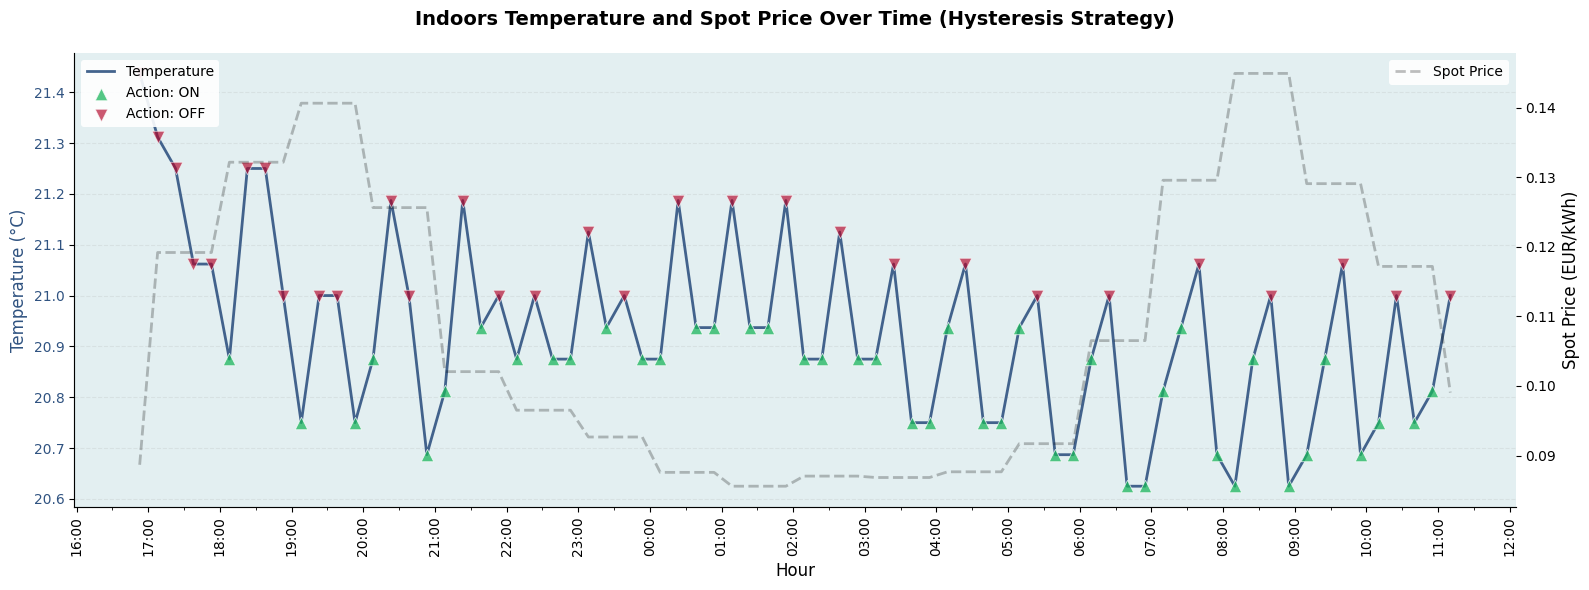

In [20]:
fig, ax1 = plt.subplots(figsize=(16, 6))
fig.set_facecolor(FRAMNA_BACKGROUND)
apply_framna_axes_style(ax1)

# Plot temperature on the left y-axis
ax1.set_xlabel('Hour', fontsize=12, fontweight="medium", color=FRAMNA_BLACK)
ax1.set_ylabel('Temperature (°C)', fontsize=12, fontweight="medium", color=FRAMNA_DARK_BLUE)
ax1.plot(
    df_hys['datetime'],
    df_hys['current_temp_c'],
    color=FRAMNA_DARK_BLUE,
    linewidth=2.0,
    alpha=0.9,
    label='Temperature',
    zorder=3,
 )
ax1.tick_params(axis='y', labelcolor=FRAMNA_DARK_BLUE)

# Add triangle indicators for ON/OFF actions
df_on = df_hys[df_hys['action'] == 'ON']
df_off = df_hys[df_hys['action'] == 'OFF']

ax1.scatter(
    df_on['datetime'],
    df_on['current_temp_c'],
    marker='^',
    s=80,
    color=FRAMNA_GREEN,
    alpha=0.75,
    edgecolors=FRAMNA_BACKGROUND,
    linewidths=0.6,
    label='Action: ON',
    zorder=5,
 )
ax1.scatter(
    df_off['datetime'],
    df_off['current_temp_c'],
    marker='v',
    s=80,
    color=FRAMNA_RED,
    alpha=0.65,
    edgecolors=FRAMNA_BACKGROUND,
    linewidths=0.6,
    label='Action: OFF',
    zorder=5,
 )

# Create a second y-axis for spot price on the right
ax2 = ax1.twinx()
ax2.set_ylabel('Spot Price (EUR/kWh)', fontsize=12, fontweight="medium", color=FRAMNA_BLACK)
ax2.plot(
    df_hys['datetime'],
    df_hys['current_spot_price_eur_kwh'],
    color=FRAMNA_BLACK,
    alpha=0.25,
    linewidth=2,
    linestyle='--',
    label='Spot Price',
    zorder=2,
 )
ax2.tick_params(axis='y', labelcolor=FRAMNA_BLACK)
ax2.grid(False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

apply_time_axis(ax1)

# Add title
ax1.set_title(
    'Indoors Temperature and Spot Price Over Time (Hysteresis Strategy)',
    fontsize=14,
    fontweight="semibold",
    pad=20,
    color=FRAMNA_BLACK,
 )

# Legends
leg1 = ax1.legend(loc='upper left', framealpha=0.9, facecolor=FRAMNA_BACKGROUND, edgecolor='none')
leg1.set_zorder(1000)
leg2 = ax2.legend(loc='upper right', framealpha=0.9, facecolor=FRAMNA_BACKGROUND, edgecolor='none')
leg2.set_zorder(1000)

fig.tight_layout()

# Print KPIs (from pre-computed costs)
print(f"Total cost: {hys_total_cost:.4f} EUR")
print(f"Energy consumed: {hys_energy_kwh:.2f} kWh")
print(f"Avg price paid: {hys_avg_price:.4f} EUR/kWh")

plt.show()


Dynamic Programming - Total cost: 0.3094 EUR
Hysteresis - Total cost: 0.3389 EUR
Cost difference: 0.0295 EUR
Savings: 8.71%
Dynamic Programming - Energy consumed: 2.86 kWh
Hysteresis - Energy consumed: 3.15 kWh
Dynamic Programming - Avg price paid: 0.1082 EUR/kWh
Hysteresis - Avg price paid: 0.1075 EUR/kWh


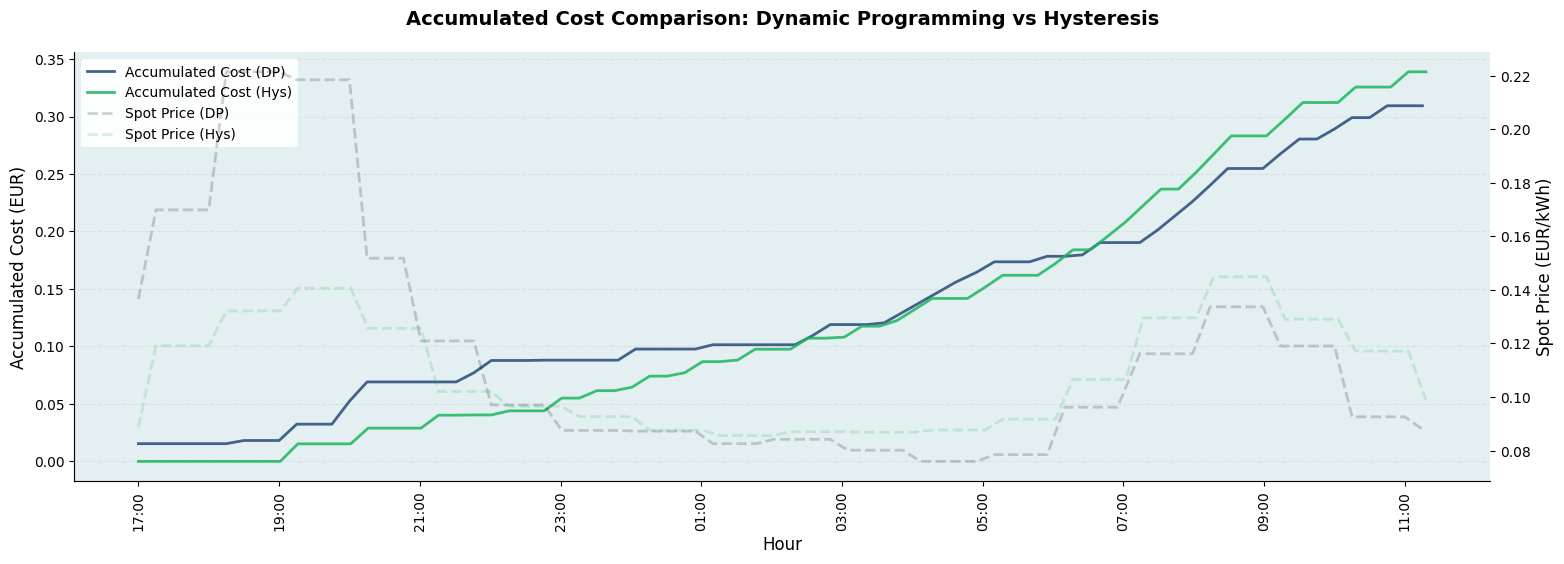

In [21]:
# Manually calculate cost from watts_on and spot price 
# cost = (watts / 1000) * hours * price_per_kwh
df_dp['calculated_cost_eur'] = (df_dp['watts_on'] / 1000) * 0.25 * df_dp['current_spot_price_eur_kwh']
df_hys['calculated_cost_eur'] = (df_hys['watts_on'] / 1000) * 0.25 * df_hys['current_spot_price_eur_kwh']

# Calculate accumulated cost over time for both strategies
df_dp['accumulated_cost'] = df_dp['calculated_cost_eur'].cumsum()
df_hys['accumulated_cost'] = df_hys['calculated_cost_eur'].cumsum()

# Create normalized time axis - extract hours and minutes, handle day wrap
df_dp['hour_minute'] = df_dp['datetime'].dt.hour + df_dp['datetime'].dt.minute / 60
df_hys['hour_minute'] = df_hys['datetime'].dt.hour + df_hys['datetime'].dt.minute / 60

start_hour_dp = df_dp['hour_minute'].iloc[0]
start_hour_hys = df_hys['hour_minute'].iloc[0]

df_dp['elapsed_hours'] = df_dp['hour_minute'].apply(lambda x: x - start_hour_dp if x >= start_hour_dp else (24 - start_hour_dp) + x)
df_hys['elapsed_hours'] = df_hys['hour_minute'].apply(lambda x: x - start_hour_hys if x >= start_hour_hys else (24 - start_hour_hys) + x)

fig, ax1 = plt.subplots(figsize=(16, 6))
fig.set_facecolor(FRAMNA_BACKGROUND)
apply_framna_axes_style(ax1)

# Plot accumulated cost on the left y-axis
line1 = ax1.plot(
    df_dp['elapsed_hours'],
    df_dp['accumulated_cost'],
    color=FRAMNA_DARK_BLUE,
    linewidth=2.0,
    label='Accumulated Cost (DP)',
    alpha=0.9,
    zorder=3,
 )
line2 = ax1.plot(
    df_hys['elapsed_hours'],
    df_hys['accumulated_cost'],
    color=FRAMNA_GREEN,
    linewidth=2.0,
    label='Accumulated Cost (Hys)',
    alpha=0.85,
    zorder=3,
 )
ax1.tick_params(axis='y', colors=FRAMNA_BLACK)

# Create a second y-axis for spot price on the right
ax2 = ax1.twinx()
ax2.set_ylabel('Spot Price (EUR/kWh)', fontsize=12, fontweight="medium", color=FRAMNA_BLACK)
line3 = ax2.plot(
    df_dp['elapsed_hours'],
    df_dp['current_spot_price_eur_kwh'],
    color=FRAMNA_BLACK,
    linewidth=2,
    label='Spot Price (DP)',
    alpha=0.18,
    linestyle='--',
    zorder=1,
 )
line4 = ax2.plot(
    df_hys['elapsed_hours'],
    df_hys['current_spot_price_eur_kwh'],
    color=FRAMNA_GREEN,
    linewidth=2,
    label='Spot Price (Hys)',
    alpha=0.18,
    linestyle='--',
    zorder=1,
 )
ax2.tick_params(axis='y', colors=FRAMNA_BLACK)
ax2.grid(False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# Set x-axis ticks at regular intervals and convert to time format
start_time = df_dp['datetime'].iloc[0]
start_time_rounded = start_time.ceil('h')
max_elapsed = int(max(df_dp['elapsed_hours'].max(), df_hys['elapsed_hours'].max())) + 2

tick_positions = range(0, max_elapsed, 2)
tick_labels = []
for elapsed in tick_positions:
    actual_time = start_time_rounded + pd.Timedelta(hours=elapsed)
    tick_labels.append(actual_time.strftime('%H:%M'))

ax1.set_xticks(tick_positions)
ax1.set_xticklabels(tick_labels)
ax1.tick_params(axis='x', rotation=90, colors=FRAMNA_BLACK)

# Apply styling to primary axis
style_ax(ax1, 'Hour', 'Accumulated Cost (EUR)', 'Accumulated Cost Comparison: Dynamic Programming vs Hysteresis')

# Combine legends from both axes
lines = line1 + line2 + line3 + line4
labels = [str(l.get_label()) for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=10, framealpha=0.9, facecolor=FRAMNA_BACKGROUND, edgecolor='none')

plt.tight_layout(pad=2.0)

# Print final totals
print(f"Dynamic Programming - Total cost: {df_dp['accumulated_cost'].iloc[-1]:.4f} EUR")
print(f"Hysteresis - Total cost: {df_hys['accumulated_cost'].iloc[-1]:.4f} EUR")
print(f"Cost difference: {abs(df_dp['accumulated_cost'].iloc[-1] - df_hys['accumulated_cost'].iloc[-1]):.4f} EUR")
print(f"Savings: {((df_hys['accumulated_cost'].iloc[-1] - df_dp['accumulated_cost'].iloc[-1]) / df_hys['accumulated_cost'].iloc[-1] * 100):.2f}%")

# Total energy consumed (kWh) - assuming 15-min intervals (0.25 hours)
dp_energy_kwh = df_dp['watts_on'].sum() / 1000 * 0.25
hys_energy_kwh = df_hys['watts_on'].sum() / 1000 * 0.25

# Energy-weighted average price (actual EUR/kWh paid)
dp_weighted_price = df_dp['calculated_cost_eur'].sum() / dp_energy_kwh if dp_energy_kwh > 0 else 0
hys_weighted_price = df_hys['calculated_cost_eur'].sum() / hys_energy_kwh if hys_energy_kwh > 0 else 0

print(f"Dynamic Programming - Energy consumed: {dp_energy_kwh:.2f} kWh")
print(f"Hysteresis - Energy consumed: {hys_energy_kwh:.2f} kWh")
print(f"Dynamic Programming - Avg price paid: {dp_weighted_price:.4f} EUR/kWh")
print(f"Hysteresis - Avg price paid: {hys_weighted_price:.4f} EUR/kWh")

plt.show()
